<a href="https://colab.research.google.com/github/hvandermarel/Colab-Notebooks/blob/main/CTB3310_A4_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CTB3310 Assignment 4 - GNSS Data Analysis (Google Colab version)

**Hans van der Marel, Delft, 5 Mar 2024**

In this assignment you will analyze the GNSS data that you collected with the help of the SW Maps app during the fieldwork outdoors. The data is stored in geopackage format which we are going to read and process in Python with the help of the GeoPandas package on-line using Google Colab.

## 0. Getting started

Before starting the GNSS data analysis a few prepatory actions are necessary.

## 0.1 Google Colab requirements

The following files are required for this assignment

- this jupyter notebook (or a copy of it),
- RD/NAP grid correction files `nlgeo2018.gtx` and `rdcorr2018.gsb`, geopackage file with Benelux coast-lines and borders, and three example geopackage files, which will be downloaded from Github by this notebook,
- the geopackage file you created during the outdoor practical, which will be downloaded from Github by this notebook,
- answer sheet template (MS Word), available from Brightspace.

One important caveat to remember while using Colab is that the files won’t be available forever. **Colab is a temporary environment with an idle timeout of 90 minutes and an absolute timeout of 12 hours**. This means that the runtime will disconnect if it has remained idle for 90 minutes, or if it has been in use for 12 hours. On disconnection, you lose all your variables, states, installed packages, and files and will be connected to an entirely new and clean environment on reconnecting.

We therefore **strongly recommend** to **save your notebook regularly** to your Google drive
> `File > Save a copy in Drive`    (first time)

> `File > Save`  

or download it to your local drive.

Only the notebook needs to be saved to Google drive. The other files are read only and can be downloaded from Github whenever necessary.

## 0.2 Download datasets and geopackage files

All the required files and datasets collected by the students are downloaded from Github. This must be done once every time a new clean session in Google Colab is started.

We start with downloading the RD/NAP grid correction files and example datasets.

In [ ]:
!wget -O CTB3310_A4_Datasets.zip https://github.com/hvandermarel/Colab-Notebooks/blob/main/datasets/CTB3310_A4_Datasets.zip?raw=true
!unzip -o CTB3310_A4_Datasets.zip

After that the data collected during the practical is downloaded. This data is stored in three subdirectories, called `mo19feb2024`, `wo21feb2024` and `do22feb2024`.

In [ ]:
!wget -O CTB3310_A4_GPKG.zip https://github.com/hvandermarel/Colab-Notebooks/blob/main/datasets/CTB3310_A4_GPKG.zip?raw=true
!unzip -o CTB3310_A4_GPKG.zip

You can see all available files using the filebrowser in the navigation menu on the left (file icon), or using bash shell commands in any of the code cells, as is shown in the following example:

In [ ]:
!pwd
!ls -l

### Link Google drive (optional)

It is easy to link a Colab session to your Google drive. This is not necessary for this notebook as all the required files are read-only. However, whenever you create or modify files, it is best to do this on your Google drive (otherwise they will disappear after time)

To mount the drive uncomment the code below

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive/', force_remount=True)

## 0.3 Install GeoPandas

GeoPandas is written in pure Python, but has several dependencies written in C (GEOS, GDAL, PROJ).

Geopandas, and several dependencies, are not installed by default in Google Colab. So, this has to be done everytime a new clean session is started in Colab. Installion is done with `pip`.

In [ ]:
!pip install geopandas mapclassify

## 1. Import packages and locate your data

## 1.1 Import packages

GeoPandas is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by `pandas` to allow spatial operations on geometric types. Geometric operations are performed by `shapely`. Geopandas further depends on `fiona` for file access, `pyproj` for coordinate transformations, `matplotlib` for plotting and a number of other packages.

For much of the work a simple import of `geopandas` is sufficient. The other packages do the work under the hood. However, sometimes, for more advanced work, it is necessary to import other packages in order to get access to more functionality form their native API's. Furthermore, for computational work rely on `numpy`.

In [ ]:
import geopandas
import fiona
import pyproj

import numpy as np
import matplotlib.pyplot as plt

The geopandas user guide can be found here https://geopandas.org/en/stable/docs/user_guide.html. More documentation is available from https://geopandas.org/en/stable/docs.html .

## 1.2 Folder structure, accompanying and geopackage files

This jupyter notebook requires the RD/NAP grid correction files `nlgeo2018.gtx` and `rdcorr2018.gsb`, geopackage file with Benelux coast-lines and borders, and three example geopackage files, to be installed in the same directory as the notebook.

To check the contents of the directories you can use your favourite file browser, the file browser on the left panel (in case of Jupyterlab) or call shell commands from within the notebook by preceeding them with an exclamation mark (!).

In [ ]:
!ls

 Volume in drive D is Data
 Volume Serial Number is FC13-3BC0

 Directory of D:\Python\education\CTB3310-2024

08-03-2024  15:04    <DIR>          .
08-03-2024  15:04    <DIR>          ..
05-03-2024  20:26    <DIR>          .ipynb_checkpoints
09-03-2023  18:29             2,176 00README.txt
03-03-2023  19:34        18,890,752 Benelux.gpkg
08-03-2024  15:04         1,060,373 CTB3310_A4_2024_v0-1_local.ipynb
09-03-2023  18:40           430,394 CTB3310_A4_GeoPandas_installation.docx
09-03-2023  18:41           779,919 CTB3310_A4_GeoPandas_installation.pdf
09-03-2023  18:33         1,669,821 CTB3310_A4_v0-4_local.html
09-03-2023  18:33         1,007,706 CTB3310_A4_v0-4_local.ipynb
26-02-2024  10:31    <DIR>          do22feb2024
23-02-2024  08:32    <DIR>          mo19feb2024
22-03-2019  12:00           579,164 nlgeo2018.gtx
03-02-2023  11:27            81,920 PracticalTest1.gpkg
17-02-2023  21:21            61,440 PracticalTest2.gpkg
20-02-2023  17:18           114,688 PracticalTest3.gpkg


## 1.3 Locate your geopackage data file ##

The geopackage files that were created by the students are stored in three subdirectories, called `mo19feb2024`, `wo21feb2024` and `do22feb2024`.

### Do this yourself ###

**One of the first things to do is to locate YOUR data file and assign the name of this file to a variable called `mydata`**

To see the available geopackage files for a specific day use something like this

In [ ]:
!ls mo19feb2024

 Volume in drive D is Data
 Volume Serial Number is FC13-3BC0

 Directory of D:\Python\education\CTB3310-2024\mo19feb2024

23-02-2024  08:32    <DIR>          .
23-02-2024  08:32    <DIR>          ..
19-02-2024  17:15           229,376 MA 7 GPKG.gpkg
19-02-2024  17:14           163,840 ma11 GPKG.gpkg
19-02-2024  17:15           147,456 MA12 GPKG.gpkg
19-02-2024  17:24           192,512 MA14 GPKG.gpkg
19-02-2024  17:12            98,304 MA16 GPKG.gpkg
19-02-2024  17:21           192,512 MA2 GPKG.gpkg
22-02-2024  14:09            69,632 MA20 GPKG.gpkg
19-02-2024  17:11           184,320 MA22 GPKG.gpkg
19-02-2024  17:14            61,440 MA5 GPKG.gpkg
19-02-2024  17:14           106,496 ma52 GPKG.gpkg
19-02-2024  17:15           151,552 MA8,9,10 GPKG.gpkg
19-02-2024  17:22           221,184 MA_group24-2 GPKG.gpkg
19-02-2024  17:13           225,280 MO 3 GPKG.gpkg
19-02-2024  17:12           188,416 MO1 GPKG.gpkg
19-02-2024  17:16           163,840 mo15 GPKG.gpkg
19-02-2024  17:13         

Do you recognize the geopackage file that was created by your group during the first practical?

If so, assign the name of the file, including the relative path, to the variable `mydata` like this

In [ ]:
#mydata = "mo19feb2024/MA 7 GPKG.gpkg"  # your dataset, change name, and uncomment to make final
mydata = "mo19feb2024/MA 7 GPKG.gpkg"

If you cannot find your dataset, or if there are problems with it, or just out of curiosity, you may also select another dataset.

**Question 1:** Write down the name(s) of the geopackage file(s) you are going to use in your report.

## 2. Read geopackage file

The GNSS data collect by SW maps is stored in a standard GIS format: a geopackage, which we have to read.

This notebooks comes with an example geopackage file called `PracticalTest2.gpkg`. You may use this package initially as a reference and study the material, however, you MAY NOT use this for your answers. We will first show you how to read the example data. After that, you will replace the example dataset with your own data.

The example geopackage name is provided in the variable `exampledata`.

In [ ]:
exampledata = "PracticalTest2.gpkg"       # example dataset

A geopackage contains multiple layers. If you used the SW Maps template provided by us, the layers are: *points*, *curves* and *Tracks*. Each layer is read into a *GeoDataFrame* object (note: Google Colab and older versions of Python may give harmless warnings which you may ignore, if you get other warnings or errors, please consider the hints given below the next code box).

If you know the names of the layers your can read them using these commands:

In [ ]:
points = geopandas.read_file(exampledata, layer='points')
lines = geopandas.read_file(exampledata, layer='curves')
tracks = geopandas.read_file(exampledata, layer='Tracks')

The above commands assume that you stored the data in three layers named *points*, *curves* and *Tracks*; these are stored in *GeoDataFrame* objects with the names *points*, *lines* and *tracks* (Note: SW Maps uses *Tracks* as default layer name, however, we call the object *tracks*, without capitals, which is more Pythonic). If one layer is missing, or if you used different names for the layers, this will result in an error.

To find out the names of the layers in the geopackage file we use `fiona`. If you find you have used different names, adjust the above commands accordingly.

In [ ]:
layers = fiona.listlayers(exampledata)
layers

['curves', 'points', 'Tracks', 'android_metadata']

To display the contents of the layers you can use print(object_name) or just type the object name (as last code line), e.g.:

In [ ]:
points

,UUID,FID,_description,latitude,longitude,elevation,ortho_ht,time,fix_id,name,control_point,remarks,geometry
0,f3df39c0-e7aa-4124-9153-bc6a1f3f2e4a,1,,51.997117,4.375868,43.16642,0.0,13-02-2023 13:18:29.000 CET,4,a1,yes,,POINT Z (4.37587 51.99712 43.16642)
1,d5d504c2-324b-41f0-8278-bb0ff06cec46,2,,51.997075,4.375872,43.17842,0.0,13-02-2023 13:19:18.000 CET,4,a2,yes,,POINT Z (4.37587 51.99708 43.17842)


In [ ]:
lines

,UUID,FID,_description,_length,type,alignment,remarks,geometry
0,867bd8a8-578f-462f-a1e5-ac3644c6bc39,3,,30.440912,road,border,,"LINESTRING Z (4.37608 51.99747 42.66542, 4.376..."
1,99b3b2eb-f81a-4745-849f-368afb296b2b,4,,25.339667,road,border,,"LINESTRING Z (4.37598 51.99731 42.81142, 4.375..."
2,af83b7ba-f2be-44d7-9f5f-d373ddee2d8b,5,,28.924731,pedestrian,border,,"LINESTRING Z (4.37587 51.99713 43.11042, 4.375..."
3,fdab2c37-7add-4902-abf3-b3036873a6ce,6,,24.601319,road,border,,"LINESTRING Z (4.37589 51.99710 42.79242, 4.375..."


In [ ]:
tracks

,UUID,remarks,start_time,end_time,geometry
0,b7862745-0e9c-4a42-b742-8b3c19257840,,13-02-2023 13:21:33.000 CET,13-02-2023 13:22:34.000 CET,"LINESTRING Z (4.37603 51.99741 42.54842, 4.376..."
1,69c779cf-3642-4545-88a7-73e17804cd13,,13-02-2023 13:32:41.000 CET,13-02-2023 13:36:29.000 CET,"LINESTRING Z (4.37589 51.99724 43.04542, 4.375..."


Each layer consists of an index, feature data and **geometry**. The geometry is in Well-Known-Text (WKT) format. In our dataset two fundamental geometries are used in their three dimensional variant: **point** and **linestring**. The WKT representation is
```
POINT Z(<lon> <lat> <hgt>)
LINESTRING Z(<lon> <lat> <hgt>, <lon> <lat> ... )
```
The **linestring** consists of a sequence of  coordinate tuples, the **point** has exactly one. The three dimensional coordinate **tuples** `(<lon> <lat> <hgt>)` provide the geographic **longitude** &lambda; and **latitude** &phi; in *degrees*, and **elevation** *h* above the ellipsoid in *meters*.
The other columns contain the attributes that where stored with the data when it was collected, such as the name and type of the feature that you entered when collecting the data, while others, such as the fix_id (4 is RTK fixed) provided by the software.

**You should only use RTK fixed (fix_id equal to 4) data. If you have used the appropriate setting (Minimum Fix Quality) in SWMAPS this is guaranteed, if not, you may occasionally have data which is not RTK fixed.**

The `android_meatadata` layer does not contain much useful information.

### Do this yourself ###

Repeat the above commands on your own dataset (For the file names see also section 0.2).

First check, using fiona, that the layer names are the ones that have been defined in the template used by SWMAPS. These should be the same as in the example. Then load the layers and display the contents. The commands are already prepared, but you may have to adjust these to your situation, and uncomment the lines. We use new layer names, do not overwrite the layers from the example; we still need those.

In [ ]:
#mylayers = fiona.listlayers(mydata)
#mylayers
mylayers = fiona.listlayers(mydata)
mylayers

['curves', 'points', 'Tracks', 'TrackPoints', 'android_metadata']

In [ ]:
#mypoints = geopandas.read_file(mydata, layer='points')
#mylines = geopandas.read_file(mydata, layer='curves')
#mytracks = geopandas.read_file(mydata, layer='Tracks')
#mytrackpoints = geopandas.read_file(mydata, layer='TrackPoints')
mypoints = geopandas.read_file(mydata, layer='points')
mylines = geopandas.read_file(mydata, layer='curves')
mytracks = geopandas.read_file(mydata, layer='Tracks')
mytrackpoints = geopandas.read_file(mydata, layer='TrackPoints')

In [ ]:
#mypoints
mypoints

,UUID,FID,_description,latitude,longitude,elevation,ortho_ht,time,fix_id,h_accuracy,v_accuracy,speed,bearing,name,control_point,remarks,geometry
0,8cfe3f04-edee-4e00-988a-7e0d8967d657,1,p2,51.99741,4.37598,42.560,0.0,19-02-2024 16:03:59.000 CET,4,0.01,0.01,0.023,0.0,,no,,POINT Z (4.37598 51.99741 42.56042)
1,d5563abc-a045-414d-8eef-4f8bf254d4b8,2,p2,51.99741,4.37598,42.570,0.0,19-02-2024 16:04:02.000 CET,4,0.01,0.01,0.004,0.0,,no,,POINT Z (4.37598 51.99741 42.57042)
2,18f10f75-9102-445a-b8ec-a36672654fee,3,p2,51.99741,4.37598,42.562,0.0,19-02-2024 16:04:03.000 CET,4,0.01,0.01,0.004,0.0,,no,,POINT Z (4.37598 51.99741 42.56242)
3,113291e5-f17d-454a-975f-b3715924f520,4,p2,51.99741,4.37598,42.564,0.0,19-02-2024 16:04:04.000 CET,4,0.01,0.01,0.008,0.0,,no,,POINT Z (4.37598 51.99741 42.56442)
4,1b8c12fe-c0de-4ed7-b079-03012b5eab0a,5,p2,51.99741,4.37598,42.562,0.0,19-02-2024 16:04:05.000 CET,4,0.01,0.01,0.005,0.0,,no,,POINT Z (4.37598 51.99741 42.56242)
5,24f33ff4-977d-487a-9a4f-f601f52a2034,6,p2,51.99741,4.37598,42.569,0.0,19-02-2024 16:04:08.000 CET,4,0.01,0.01,0.007,0.0,,no,,POINT Z (4.37598 51.99741 42.56942)
6,9ac527e0-d04b-4919-baa9-e53cd248e11f,7,p2,51.99741,4.37598,42.570,0.0,19-02-2024 16:04:10.000 CET,4,0.01,0.01,0.006,0.0,,no,,POINT Z (4.37598 51.99741 42.57042)
7,c09ff94e-e8d6-443b-a689-c3961c39b2af,8,p2,51.99741,4.37598,42.568,0.0,19-02-2024 16:04:12.000 CET,4,0.01,0.01,0.013,0.0,,no,,POINT Z (4.37598 51.99741 42.56842)
8,d88d3cc0-b7ef-46a9-8a7a-8b0a9156335b,9,p2,51.99741,4.37598,42.568,0.0,19-02-2024 16:04:13.000 CET,4,0.01,0.01,0.011,0.0,,no,,POINT Z (4.37598 51.99741 42.56842)


In [ ]:
#mylines
mylines

,UUID,FID,_description,_length,type,alignment,remarks,geometry
0,7dc2fdef-ca16-4c6e-9e96-13bad31489d2,10,,37.401,bicycle path,border,,"LINESTRING Z (4.37613 51.99745 42.73642, 4.376..."


In [ ]:
#mytracks
mytracks

,UUID,name,remarks,start_time,end_time,geometry
0,8db98382-a69f-441f-b7dc-22d56d8c4e35,P2 tripod,,19-02-2024 16:11:47.000 CET,19-02-2024 16:17:48.000 CET,"LINESTRING Z (4.37598 51.99741 42.56742, 4.375..."
1,a1493aa0-694c-4715-be97-78531ba3beda,Track grid,,19-02-2024 16:29:06.000 CET,19-02-2024 16:31:39.000 CET,"LINESTRING Z (4.37604 51.99733 42.81642, 4.376..."
2,3dd67135-728b-43bb-a399-7d6b1e7dc4c1,Track grid extra,,19-02-2024 16:33:28.000 CET,19-02-2024 16:36:26.000 CET,"LINESTRING Z (4.37604 51.99733 42.84742, 4.376..."


In [ ]:
#mytrackpoints
mytrackpoints

,TRK_UUID,name,latitude,longitude,elevation,ortho_ht,time,fix_id,h_accuracy,v_accuracy,speed,bearing,geometry
0,8db98382-a69f-441f-b7dc-22d56d8c4e35,P2 tripod,51.997410,4.375980,42.567,0.0,19-02-2024 16:11:47.000 CET,4,0.01,0.01,0.002,13.00,POINT Z (4.37598 51.99741 42.56742)
1,8db98382-a69f-441f-b7dc-22d56d8c4e35,P2 tripod,51.997410,4.375980,42.568,0.0,19-02-2024 16:11:48.000 CET,4,0.01,0.01,0.004,13.00,POINT Z (4.37598 51.99741 42.56842)
2,8db98382-a69f-441f-b7dc-22d56d8c4e35,P2 tripod,51.997410,4.375980,42.560,0.0,19-02-2024 16:11:49.000 CET,4,0.01,0.01,0.002,13.00,POINT Z (4.37598 51.99741 42.56042)
3,8db98382-a69f-441f-b7dc-22d56d8c4e35,P2 tripod,51.997410,4.375980,42.567,0.0,19-02-2024 16:11:50.000 CET,4,0.01,0.01,0.001,13.00,POINT Z (4.37598 51.99741 42.56742)
4,8db98382-a69f-441f-b7dc-22d56d8c4e35,P2 tripod,51.997410,4.375980,42.565,0.0,19-02-2024 16:11:51.000 CET,4,0.01,0.01,0.002,13.00,POINT Z (4.37598 51.99741 42.56542)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,3dd67135-728b-43bb-a399-7d6b1e7dc4c1,Track grid extra,51.997060,4.376006,42.985,0.0,19-02-2024 16:36:22.000 CET,4,0.01,0.01,0.994,163.23,POINT Z (4.37601 51.99706 42.98542)
691,3dd67135-728b-43bb-a399-7d6b1e7dc4c1,Track grid extra,51.997055,4.376005,42.902,0.0,19-02-2024 16:36:23.000 CET,4,0.01,0.01,0.601,212.97,POINT Z (4.37601 51.99705 42.90242)
692,3dd67135-728b-43bb-a399-7d6b1e7dc4c1,Track grid extra,51.997053,4.375998,42.947,0.0,19-02-2024 16:36:24.000 CET,4,0.01,0.01,0.670,257.19,POINT Z (4.37600 51.99705 42.94742)
693,3dd67135-728b-43bb-a399-7d6b1e7dc4c1,Track grid extra,51.997052,4.375989,42.959,0.0,19-02-2024 16:36:25.000 CET,4,0.01,0.01,0.653,263.90,POINT Z (4.37599 51.99705 42.95942)


The layer **TrackPoints** is a recent addition by SWMAPS that was not yet present in the example dataset. This layer contains the same data as the layer **Tracks**, but now stored as points with some additional (and very useful) attributes.

Another recent addition by SWMAPS are the *accuracy*, *speed* and *bearing* attributes in the **points** and **trackPoints** layers. The *accuracy* attribute is a welcome addition to the *fix_id* attribute.

To find out the names in the **trackPoints** layer you can do something like this

In [ ]:
mytrackpoints.name.unique()

array(['P2 tripod', 'Track grid', 'Track grid extra'], dtype=object)

Unfortunately, the *fix_id* and *accuracy* are not stored as attributes in the **curves** (lines) layer; so unless you have set the *Minumum fix quality* in SWMAPS to "RTK fix" you cannot be sure this data has the required quality.

**Question 2:** What is the accuracy of your data, and is all data "RTK fixed"? Mention this in your report. If there are any surprises mention this as well.

## 3. Mapping and Plotting Topography

Mapping and plotting your data is often one of the first things to do.

## 3.1 Plotting layers and tracks

GeoPandas provides a high-level interface to the `matplotlib` library for making maps. Mapping shapes is as easy as using the `plot()` method on a GeoSeries or GeoDataFrame.

<Axes: >

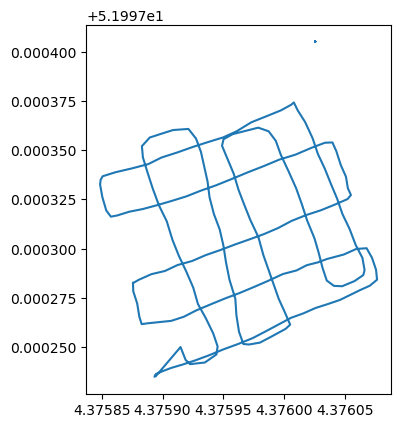

In [ ]:
tracks.plot()

This is not a very good plot as labels and a title is missing, we show below how to add these.

## 3.2 Plotting multiple layers

For making a map with multiple layers, first remember to always ensure they share a common Coordinate Reference System (CRS), so they will align. In our dataset this is (still) the case as the layers come from the same source. To create a map with multiple layers we call the plot method on individual layers with options.

Note that in general, any options one can pass to pyplot in matplotlib (or style options that work for lines) can be passed to the plot() method.

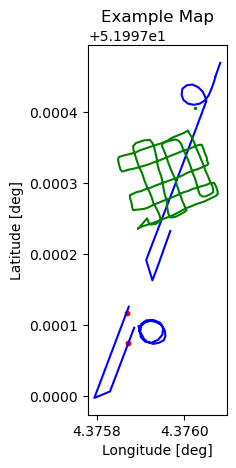

In [ ]:
base = lines.plot(color='blue')
points.plot(ax=base, marker='o', color='red', markersize=10)
tracks.plot(ax=base, color='green')
base.set(xlabel='Longitude [deg]', ylabel='Latitude [deg]', title='Example Map');

### Do this yourself ###

Recreate the above plot for your own dataset

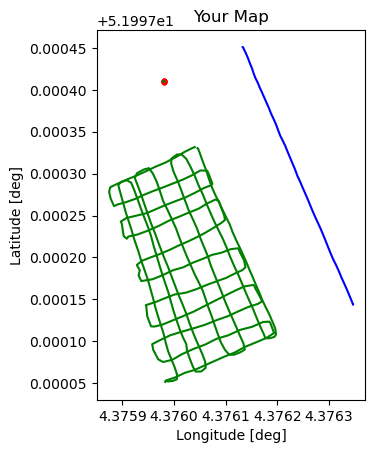

In [ ]:
mybase = mylines.plot(color='blue')
mypoints.plot(ax=mybase, marker='o', color='red', markersize=10)
mytracks.plot(ax=mybase, color='green')
mybase.set(xlabel='Longitude [deg]', ylabel='Latitude [deg]', title='Your Map');

**Question 3:** Include this plot/map in your report.

### Aspect ratio ###

The *GeoPandas* plot() method is smart: it takes into account the fact that - except at the equator - one degree in latitude is not the same distance as one degree in longitude!

When using the *GeoPandas* plot() method the aspect ratio is set automatically to *equal* (note that this is not done when working with pyplot directly).

To illustrate this point we redo the previous map, using a slightly different method to plot multiple layers using `pyplot`, and set the **aspect ratio** to **one**.

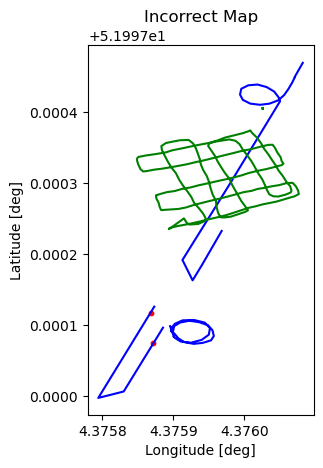

In [ ]:
fig, ax = plt.subplots()

lines.plot(ax=ax, color='blue')
points.plot(ax=ax, marker='o', color='red', markersize=10)
tracks.plot(ax=ax, color='green')
ax.set(xlabel='Longitude [deg]', ylabel='Latitude [deg]', title='Incorrect Map')

ax.set_aspect(1)

plt.show();

Clearly, this is not the way latitude and longitude data should be plotted (you are warned!). When you plot latitude and longitude data always set the appropriate aspect ratio.

### Do this yourself ###

The aspect ratio can be computed using formula (29.7) from the Surveying and Mapping book, section 29.2.2, whereby you may assume that the curvatures are equal. You can also calculate the aspect ratio from the plot in Question 3 by measuring, with a ruler, the length on the map corresponding to 0.0001 deg in latitude and to 0.0001 deg in longitude.  

In [ ]:
#ratio_computed =                         # from Eg 29.7, assuming M(phi) and N(phi) are equal
#ratio_measured_in_map =   /              # mm for 0.0001 deg in latitude resp. longitude
#print('ratio computed:', ratio_computed, ', measured in map:', ratio_measured_in_map )

Hint: if you don't have a ruler, use a snipping tool (e.g. snip&sketch in Windows) with a build in ruler.

**Question 4:** Explain in your report why the aspect ratio is not one, and report the aspect ratio computed using formula (29.7) in the Surveying and Mapping book and the aspect ratio aspect ratio measured using a ruler from the plot in Question 3.

Check the computed (and measured) aspect ratio by adjusting the aspect ratio in the previous plot using the ratio computed in question 4.  You do not have to give the plot in your report (but it is a good check to your answer in question 4 ...):

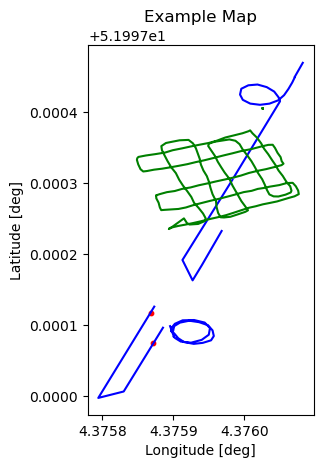

In [ ]:
fig, ax = plt.subplots()

lines.plot(ax=ax, color='blue')
points.plot(ax=ax, marker='o', color='red', markersize=10)
tracks.plot(ax=ax, color='green')
ax.set(xlabel='Longitude [deg]', ylabel='Latitude [deg]', title='Example Map')

ax.set_aspect(1)     # !!! replace this with your value !!!

plt.show();

However, if you want to do geometric computations, such as computing areas, it is a much better idea to use a map projection, as we will explore later.

## 3.3 Interactive mapping

GeoPandas can also create interactive maps based on the `folium` library (under the hood in geopandas). Creating maps for interactive exploration uses the `explore()` method of a GeoSeries or GeoDataFrame.

The `explore()` method returns a `folium.Map` object, which can also be passed directly (as you did with ax in plot()). In the example below, we plot our three layers on the same map by passing the folium.Map object to subsequent layers (using *m* instead of *ax* keywords).

It may take some time to generate the interactive map, so be patient, and also you may be asked to "make this notebook thrusted" to load the map (answer yes).

In [ ]:
fm = lines.explore(color='blue')
points.explore(m=fm, color='red')
tracks.explore(m=fm, color='green')

Hovering over a feature shows a popup with all the feature attributes.

### Do this yourself ###

Create the interactive map for your dataset.

In [ ]:
# put your code here

fm = mylines.explore(color='blue')
mypoints.explore(m=fm, color='red')
mytracks.explore(m=fm, color='green')

 You don't have to include this in your report.

**These interactive maps, and the popups created by hovering over a feature, are very useful to identify features in your dataset that you may need for further analysis. So, when you need to identify a feature in your dataset for one of the questions, you can come back to this interactive map to find it!**

After importing folium you can also use folium functionality directly on the resulting map, e.g. adding additional tiles allowing you to change the background directly in the map. We leave this to you to experiment (after consulting geopandas and folium documentation).

Note that to display the background tiles in the correct position, and to get the aspect ratio correct as with the static matplotlib plots, the correct Coordinate Reference System (CRS) must have been set in the GeoDataFrame. This is something we deal with in the next section.

> ### A note on interactive mapping (QGIS promotion, for your information)
>
> Interactive mapping may seem a nice and useful feature of GeoPandas. However for true interactive mapping we recommend using a GIS system, such as ArcGIS or the freely available **QGIS** that will be used in assignment 5 and 6.
> To obtain more or less the same result in QGIS:
> 1. open a new QGIS project,
> 2. double click `browser > XYZ Tiles > OpenStreetMap`,
> 3. add your geopackage file using `Layer > Add Layer > Add Vector Layer` .
>
> Do not forget to set your project CRS to e.g. EPSG:28992 (otherwise you have this very unprofessional distorted latitude/longitude reference system.   

## 4. Coordinate Reference System (CRS)

A GeoDataFrame needs to have a Coordinate Reference System (CRS) set to perform spatial analyses and enable coordinate transformations.

## 4.1 Obtaining CRS information

To obtain information on the CRS use the `.crs` attribute on a GeoDataFrame or GeoSeries.

In [ ]:
lines.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
print(lines.crs)

EPSG:4326


An important element is the EPSG code. Each geodetic datum, spatial reference system, Earth ellipsoid, coordinate transformation and related units of measurements is assigned an EPSG code between 1024 and 32767, that corresponds to a public registry in the EPSG Geodetic Parameter Dataset, originated by a member of the European Petroleum Survey Group (EPSG) in 1985, and maintained by the IOGP Geomatics Committee, see also Section 31.4 in the book.

Common EPSG codes are

* EPSG:4326 - WGS 84, latitude/longitude coordinate system based on the Earth's center of mass, used by the Global Positioning System among others.
* EPSG:3857 - Web Mercator projection used for display by many web-based mapping tools, including Google Maps and OpenStreetMap.
* EPSG:7789 - International Terrestrial Reference Frame 2014 (ITRF2014), an Earth-fixed system that is independent of continental drift.
* EPSG:4258 - European Terrestrial Reference Frame 1989 (ETRS89), an Earth-Fixed system moving along with the Eurasian Plate, defined only for the European continent.
* EPSG:28992 - Projected coordinate system for Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.

These systems are covered later in class and in part V of the book.

Our data is apparently in WGS84, but as we will find out later, this is not entirely correct (to be precise: it is the national realization of ETRS89). Coordinates are given as longitude &lambda;, latitude &phi; and elevation (height) *h* above the ellipsoid, cf. Figure 29.2 of the book.

Another way to describe the CRS that is used is by the standard machine-readable well-known text (WKT) representation using the *to_wrt()* method:

In [ ]:
print(lines.crs.to_wkt(pretty=True))

GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    USAGE[
        SCOPE["Horizontal component of 3D system."],
        AREA["World."],
      

## 4.2 Coordinate Reference System (CRS) transformations with GeoPandas

Coordinate Reference System (CRS) transformations with GeoPandas is made ''easy'' using the `pyproj` package, the Python interface to **PROJ** (cartographic projections and coordinate transformations library), under the hood.

> PROJ is a generic coordinate transformation software written in C that transforms geospatial coordinates from one coordinate reference system (CRS) to another. This includes cartographic projections as well as geodetic transformations, cf. Figure 31.1 of the book. PROJ includes an API as well as command line applications. PROJ started purely as a cartography application letting users convert geodetic coordinates into projected coordinates using a number of different cartographic projections. Over the years, as the need has become apparent, support for datum shifts has slowly worked its way into PROJ as well. Today PROJ supports more than a hundred different map projections and can transform coordinates between datums using all but the most obscure geodetic techniques. PROJ has become the de-facto standard for coordinate transformations all around the World. See also Section 31.5 of the book.

GeoPandas provides a high-level interface to PROJ using the `to_crs()` method on a GeoSeries or GeoDataFrame.

The next examples show how to transform the example GeoDataFrames to the Dutch projected coordinate system, called RD (RijksDriehoeksmeting), cf. Figure 35.2:

In [ ]:
points_rd = points.to_crs("EPSG:28992")
lines_rd = lines.to_crs("EPSG:28992")
tracks_rd = tracks.to_crs("EPSG:28992")

In [ ]:
lines_rd.crs

<Derived Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [ ]:
points_rd

,UUID,FID,_description,latitude,longitude,elevation,ortho_ht,time,fix_id,name,control_point,remarks,geometry
0,f3df39c0-e7aa-4124-9153-bc6a1f3f2e4a,1,,51.997117,4.375868,43.16642,0.0,13-02-2023 13:18:29.000 CET,4,a1,yes,,POINT Z (85546.727 445898.267 43.166)
1,d5d504c2-324b-41f0-8278-bb0ff06cec46,2,,51.997075,4.375872,43.17842,0.0,13-02-2023 13:19:18.000 CET,4,a2,yes,,POINT Z (85546.876 445893.669 43.178)


In [ ]:
lines_rd

,UUID,FID,_description,_length,type,alignment,remarks,geometry
0,867bd8a8-578f-462f-a1e5-ac3644c6bc39,3,,30.440912,road,border,,"LINESTRING Z (85562.008 445937.457 42.665, 855..."
1,99b3b2eb-f81a-4745-849f-368afb296b2b,4,,25.339667,road,border,,"LINESTRING Z (85554.954 445919.233 42.811, 855..."
2,af83b7ba-f2be-44d7-9f5f-d373ddee2d8b,5,,28.924731,pedestrian,border,,"LINESTRING Z (85547.111 445899.445 43.110, 855..."
3,fdab2c37-7add-4902-abf3-b3036873a6ce,6,,24.601319,road,border,,"LINESTRING Z (85548.511 445896.376 42.792, 855..."


As you can observe from the GeoDataFrames the *geometry* has changed, but not the other attributes! (the point GeoDataFrame still has attributes latitude and longitude from the original).
Also note the transformation **DID NOT change the elevation** (the third coordinate). The height coordinate is still given as elevation above the original ellipsoid!

Below the data is plotted in the new CRS:

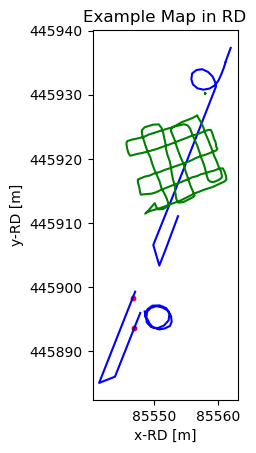

In [ ]:
base = lines_rd.plot(color='blue')
points_rd.plot(ax=base, marker='o', color='red', markersize=10)
tracks_rd.plot(ax=base, color='green')
base.set(xlabel='x-RD [m]', ylabel='y-RD [m]', title='Example Map in RD');

The aspect ratio is now one (as we would expect from projected coordinates).

### Do this yourself ###

Recreate the above plot for your own dataset.

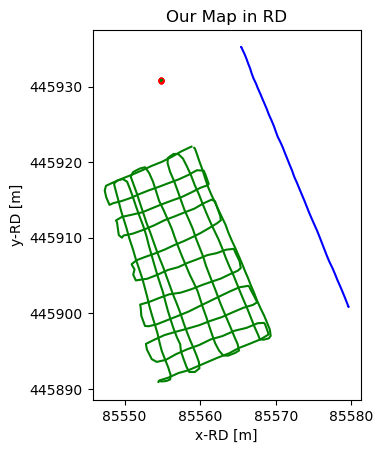

In [ ]:
# mypoints_rd = mypoints.to_crs("EPSG:28992")
# ...
# mybase = mylines_rd.plot(color='blue')
# ...

mypoints_rd = mypoints.to_crs("EPSG:28992")
mylines_rd = mylines.to_crs("EPSG:28992")
mytracks_rd = mytracks.to_crs("EPSG:28992")

mybase = mylines_rd.plot(color='blue')
mypoints_rd.plot(ax=mybase, marker='o', color='red', markersize=10)
mytracks_rd.plot(ax=mybase, color='green')
mybase.set(xlabel='x-RD [m]', ylabel='y-RD [m]', title='Our Map in RD');

**Question 5: Include this map in RD in your report.**

### EPSG:28992 Limitations, BEWARE ! ###

The above coordinate transformation has two main limitations: it is approximate, and it only operates on the horizontal coordinates. This is good enough for plotting, but not enough for mathematical analysis.

> The coordinate transformation from EPSG:4326 (WGS-84) to EPSG:28992 has only an accuracy of about 1 meter. See also https://epsg.io/28992-to-4326 . This is mainly for two reasons: we actually have geographic coordinates in ETRS89 instead of WGS-84 and because a correction grid for RD was not used. Later we will show how to do a more accurate transformation, and why this is important.

We will also discuss later how to convert the elevation above the ellipsoid into the Amsterdam Ordance datum, in Dutch, Normaal Amsterdam Peil (NAP). This is important because there is a difference of about 42 meters between the elevation above the ellipsoid and NAP heights, cf. Figure 35.10 (hey, you didn't believe we were 40 meters above sea-level in Delft, really?).

## 5. Data selections with GeoPandas (and Pandas) and conversion to numpy

So far we were not very specific in what we plotted. However, for further analysis of the data, we have to be able to select specific features (e.g. a point or track) that we want to analyze. How to do these selections, and how to convert the selected data into a `numpy` array, is explained below.

**Please note that groups did their measurements in a different order and used different names and attribute values. You may have to adjust the indices and names to match your data.**

## 5.1. Selecting rows (features and tracks)

GeoDataFrames are an extension of Panda's dataframes. This means you can select rows using the `loc[]`, `iloc[]` and `query()` methods. This is best ilustrated with examples:

In [ ]:
lines.iloc[[0]]

,UUID,FID,_description,_length,type,alignment,remarks,geometry
0,867bd8a8-578f-462f-a1e5-ac3644c6bc39,3,,30.440912,road,border,,"LINESTRING Z (4.37608 51.99747 42.66542, 4.376..."


In [ ]:
lines.iloc[[0,1]]

,UUID,FID,_description,_length,type,alignment,remarks,geometry
0,867bd8a8-578f-462f-a1e5-ac3644c6bc39,3,,30.440912,road,border,,"LINESTRING Z (4.37608 51.99747 42.66542, 4.376..."
1,99b3b2eb-f81a-4745-849f-368afb296b2b,4,,25.339667,road,border,,"LINESTRING Z (4.37598 51.99731 42.81142, 4.375..."


In [ ]:
lines.loc[[0,1]]

,UUID,FID,_description,_length,type,alignment,remarks,geometry
0,867bd8a8-578f-462f-a1e5-ac3644c6bc39,3,,30.440912,road,border,,"LINESTRING Z (4.37608 51.99747 42.66542, 4.376..."
1,99b3b2eb-f81a-4745-849f-368afb296b2b,4,,25.339667,road,border,,"LINESTRING Z (4.37598 51.99731 42.81142, 4.375..."


In [ ]:
lines.query( "type == 'road'" )

,UUID,FID,_description,_length,type,alignment,remarks,geometry
0,867bd8a8-578f-462f-a1e5-ac3644c6bc39,3,,30.440912,road,border,,"LINESTRING Z (4.37608 51.99747 42.66542, 4.376..."
1,99b3b2eb-f81a-4745-849f-368afb296b2b,4,,25.339667,road,border,,"LINESTRING Z (4.37598 51.99731 42.81142, 4.375..."
3,fdab2c37-7add-4902-abf3-b3036873a6ce,6,,24.601319,road,border,,"LINESTRING Z (4.37589 51.99710 42.79242, 4.375..."


The `loc[]` and `iloc[]` methods produce similar results, this is because the *index* is numerical. We can set any column as index, e.g.

In [ ]:
points_idx = points.set_index('name')
points_idx

,UUID,FID,_description,latitude,longitude,elevation,ortho_ht,time,fix_id,control_point,remarks,geometry
name,,,,,,,,,,,,
a1,f3df39c0-e7aa-4124-9153-bc6a1f3f2e4a,1,,51.997117,4.375868,43.16642,0.0,13-02-2023 13:18:29.000 CET,4,yes,,POINT Z (4.37587 51.99712 43.16642)
a2,d5d504c2-324b-41f0-8278-bb0ff06cec46,2,,51.997075,4.375872,43.17842,0.0,13-02-2023 13:19:18.000 CET,4,yes,,POINT Z (4.37587 51.99708 43.17842)


In [ ]:
points_idx.loc[['a1']]

,UUID,FID,_description,latitude,longitude,elevation,ortho_ht,time,fix_id,control_point,remarks,geometry
name,,,,,,,,,,,,
a1,f3df39c0-e7aa-4124-9153-bc6a1f3f2e4a,1,,51.997117,4.375868,43.16642,0.0,13-02-2023 13:18:29.000 CET,4,yes,,POINT Z (4.37587 51.99712 43.16642)


The type that is returned is always a GeoPandas geodataframe (Note: if single `[]` are used, with one row, a Pandas series is returned)

In [ ]:
print(type(lines.loc[[0]]))

<class 'geopandas.geodataframe.GeoDataFrame'>


## 5.2 Selecting columns and geometries

Specific columns can be selected as well, using e.g. the following syntax

In [ ]:
points_idx[['longitude', 'latitude']]

,longitude,latitude
name,,
a1,4.375868,51.997117
a2,4.375872,51.997075


There is purpose behind using `[[ ]]` or `[]`. The first returns a Pandas dataframe, the second a Pandas series:

In [ ]:
print(type(points_idx[['latitude']]))
print(type(points_idx['latitude']))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


The geometry is something special. If this is included a GeoPandas GeoDataFrame or GeoSeries is returned:

In [ ]:
print(type(points_idx[['geometry']]))
points_idx[['geometry']]

<class 'geopandas.geodataframe.GeoDataFrame'>


,geometry
name,
a1,POINT Z (4.37587 51.99712 43.16642)
a2,POINT Z (4.37587 51.99708 43.17842)


In [ ]:
print(type(points_idx['geometry']))
points_idx['geometry']

<class 'geopandas.geoseries.GeoSeries'>


name
a1    POINT Z (4.37587 51.99712 43.16642)
a2    POINT Z (4.37587 51.99708 43.17842)
Name: geometry, dtype: geometry

## 5.3 Converting geometries into numpy arrays with coordinates  

In the previous section the geometry was retrieved in the typical Pandas way using a column selection. This is so important that this has been implemented in GeoPandas as `geometry` method.
This method is used, together with other methods, to retrieve the coordinates as `numpy` arrays for further analysis.

We show this with a couple of examples.

The `geometry` method returns what is called a *GeoSeries* (the equivalent of a Pandas data series).

In [ ]:
print(type(points_idx.geometry))
points_idx.geometry

<class 'geopandas.geoseries.GeoSeries'>


name
a1    POINT Z (4.37587 51.99712 43.16642)
a2    POINT Z (4.37587 51.99708 43.17842)
Name: geometry, dtype: geometry

To obtain the `wkt` representation as string the *wkt* method can be used on a single instance of a *geometry* object:

In [ ]:
print(type(points_idx.geometry[0].wkt))
points_idx.geometry[0].wkt

<class 'str'>


'POINT Z (4.375868448333334 51.99711651 43.16642)'

To obtain the coordinates use `coords` (from the `shapely` package) on a single geometry instance, and then convert to a list with coordinate *tuples* or a two-dimensional numpy *array*:

In [ ]:
print(type(points_idx.geometry[0].coords))
print(list(points_idx.geometry[0].coords))
np.array(points_idx.geometry[0].coords)

<class 'shapely.coords.CoordinateSequence'>
[(4.375868448333334, 51.99711651, 43.16642)]


array([[ 4.37586845, 51.99711651, 43.16642   ]])

Doing this on LINESTRING returns a fully populated two-dimensional numpy array:

In [ ]:
np.array(lines.geometry[0].coords)

array([[ 4.37608299, 51.99747063, 42.66542   ],
       [ 4.3760709 , 51.99744949, 42.63942   ],
       [ 4.37607125, 51.99744916, 42.63242   ],
       [ 4.37607101, 51.99744919, 42.63442   ],
       [ 4.37607093, 51.9974492 , 42.63442   ],
       [ 4.37607042, 51.99744778, 42.67942   ],
       [ 4.37606734, 51.99744146, 42.66942   ],
       [ 4.37606203, 51.99743249, 42.67442   ],
       [ 4.37605589, 51.99742374, 42.71942   ],
       [ 4.37604761, 51.99741651, 42.71242   ],
       [ 4.37603535, 51.99741185, 42.67742   ],
       [ 4.37602199, 51.99741022, 42.68542   ],
       [ 4.37600823, 51.99741191, 42.63842   ],
       [ 4.37599777, 51.9974172 , 42.63842   ],
       [ 4.37599386, 51.99742463, 42.63442   ],
       [ 4.37599565, 51.99743283, 42.63142   ],
       [ 4.37600559, 51.9974377 , 42.64642   ],
       [ 4.37601849, 51.99743878, 42.66642   ],
       [ 4.37603148, 51.99743514, 42.68442   ],
       [ 4.37604201, 51.99742885, 42.69142   ],
       [ 4.37604786, 51.99742119, 42.660

Having the coordinates as numpy array means that you can do a lot of other stuff on the data and perform analyses. For example, you can compute the mean and standard deviation of the repeated measurements on the static point (new benchmark) that you created.

## 6. Analysis of the benchmark measurements

## 6.1 Why benchmarks?

It is always good practice when you go out into the field to measure in addition to your data at least two existing points (benchmarks) with known coordinates. The reason is that you can thus check your measurements for big mistakes, consistency with previous measurements and to add realibility to the measurement campaign. When you come back another day, you certainly want to be sure that the new measurements match the previous ones, and that they are compatible with other projects.

Also, whenever you start a new project, it is stronly recommended to create a few new benchmarks (points) that you can revisit on subsequent visits to the site (not having to travel kilometers to a "far far away" national benchmark. To create a new benchmark it is custom to average over a period of time, so that you get a slightly better precision for the new coordinates (this is an option in SW Maps).

This was done in example dataset.

However, we did ask you - for educational purposes - to do this a bit differently:

* Record data for several minutes with the pole on one of the benchmark using a small tripod, this data is recorded as a track,
* Measure the same benchmark at least ten times without tripod, this data is recorded in the points layer.

The purpose of the first experiment is to get an idea of the spread/variability in the positions due to GNSS measurement noise, the purpose of second experiment is to get an idea of the spread/variability in the positions primarily due to the surveyor holding the range pole, along with any biases.

We start with the analysis of the GNSS measurement precision, after that we will compare the coordinate values of the two existing points with their known values to obtain the bias.

## 6.2 Analysis of the GNSS measurement precision - Part 1

During the practical you collected measurements over about three minutes whereby the pole was fixed using a small tripod. This data can be used to assess the internal measurement precision of the GNSS system.

In the example dataset this was the first track (but this  may be different in yours!); we set this in the variable `benchmark_trackidx`.

In [ ]:
tracks

,UUID,remarks,start_time,end_time,geometry
0,b7862745-0e9c-4a42-b742-8b3c19257840,,13-02-2023 13:21:33.000 CET,13-02-2023 13:22:34.000 CET,"LINESTRING Z (4.37603 51.99741 42.54842, 4.376..."
1,69c779cf-3642-4545-88a7-73e17804cd13,,13-02-2023 13:32:41.000 CET,13-02-2023 13:36:29.000 CET,"LINESTRING Z (4.37589 51.99724 43.04542, 4.375..."


In [ ]:
benchmark_trackidx=0

To analyze the precision you have to compute the standard deviation. Below we use the methods *mean* and *std*:

In [ ]:
static_point_coords = np.array(tracks.geometry[benchmark_trackidx].coords)
print('shape',static_point_coords.shape)

tripod_mean_llh = static_point_coords.mean(axis=0)
tripod_stdev_llh = static_point_coords.std(axis=0, ddof=1)

print('mean',tripod_mean_llh, 'in deg/deg/m')
print('stdev',tripod_stdev_llh, 'in deg/deg/m')

shape (59, 3)
mean [ 4.3760257  51.99740506 42.55170814] in deg/deg/m
stdev [2.36424722e-08 1.91788290e-08 3.07408998e-03] in deg/deg/m


Obviously, it is not very useful to have the standard deviation both in degrees and meters, especially because latitude and longitude can not be compared with each other. To have the statistics all in meters you can convert the coordinates to a grid system, e.g. the Dutch RD system, using the `to_crs()` method. The results are:

In [ ]:
static_point_rdcoords = np.array(tracks.to_crs('EPSG:28992').geometry[benchmark_trackidx].coords)
print('shape',static_point_rdcoords.shape)

tripod_mean_rd = static_point_rdcoords.mean(axis=0)
tripod_stdev_rd = static_point_rdcoords.std(axis=0, ddof=1)

print('mean',tripod_mean_rd, 'in m/m/m')
print('stdev',tripod_stdev_rd*1000, 'in mm/mm/mm')

shape (59, 3)
mean [8.55579720e+04 4.45930218e+05 4.25517081e+01] in m/m/m
stdev [1.60866585 2.14524589 3.07408998] in mm/mm/mm


The first coordinate is in the East direction (x), the second in the North direction (y) and the third in the vertical (elevation).

**Note**: Even though the `EPSG:28992` transformation has (officially) only 1 meter accuracy it can still be used for computing statistics such as the standard deviation: this is because for a given location the error in the transformation is the same (hence it does not affect the standard deviation, only the mean).

Therefore, the useful results are only  `tripod_mean_llh` (mean latitude, longitude and height) because this is not affected by the approximate transformation and `tripod_stdev_rd` (standard deviation of the x-RD, y-RD and height in meters) because to have the standard deviations in meters (or mm) is so much more convenient than degrees and meters.

### Do this yourself ###

Repeat the above computations for your own dataset.

* first identify the index number of the appropriate track and set the value in `my_benchmark_trackidx`
* compute the means and standard deviations
* create the scatter plot
* create the plot with three histograms

In [ ]:
mytracks

,UUID,name,remarks,start_time,end_time,geometry
0,8db98382-a69f-441f-b7dc-22d56d8c4e35,P2 tripod,,19-02-2024 16:11:47.000 CET,19-02-2024 16:17:48.000 CET,"LINESTRING Z (4.37598 51.99741 42.56742, 4.375..."
1,a1493aa0-694c-4715-be97-78531ba3beda,Track grid,,19-02-2024 16:29:06.000 CET,19-02-2024 16:31:39.000 CET,"LINESTRING Z (4.37604 51.99733 42.81642, 4.376..."
2,3dd67135-728b-43bb-a399-7d6b1e7dc4c1,Track grid extra,,19-02-2024 16:33:28.000 CET,19-02-2024 16:36:26.000 CET,"LINESTRING Z (4.37604 51.99733 42.84742, 4.376..."


In [ ]:
my_benchmark_trackidx=0

In [ ]:
static_point_coords = np.array(mytracks.geometry[my_benchmark_trackidx].coords)
print('shape',static_point_coords.shape)

tripod_mean_llh = static_point_coords.mean(axis=0)
tripod_stdev_llh = static_point_coords.std(axis=0, ddof=1)

print('mean',tripod_mean_llh, 'in deg/deg/m')
print('stdev',tripod_stdev_llh, 'in deg/deg/m')

shape (362, 3)
mean [ 4.37598015 51.99741013 42.56810785] in deg/deg/m
stdev [3.94475366e-08 2.86949108e-08 6.70215712e-03] in deg/deg/m


In [ ]:
static_point_rdcoords = np.array(mytracks.to_crs('EPSG:28992').geometry[my_benchmark_trackidx].coords)
print('shape',static_point_rdcoords.shape)

tripod_mean_rd = static_point_rdcoords.mean(axis=0)
tripod_stdev_rd = static_point_rdcoords.std(axis=0, ddof=1)

print('mean',tripod_mean_rd, 'in m/m/m')
print('stdev',tripod_stdev_rd*1000, 'in mm/mm/mm')

shape (362, 3)
mean [8.55548519e+04 4.45930825e+05 4.25681078e+01] in m/m/m
stdev [2.73585615 3.16975123 6.70215712] in mm/mm/mm


**Question 6:** include the standard deviations, with the appropriate number of significant digits (think about this), in your report. Are these standard deviations what you would expect from `RTK-fixed` solutions?

Also nice is to plot a scatter diagram of the positions:

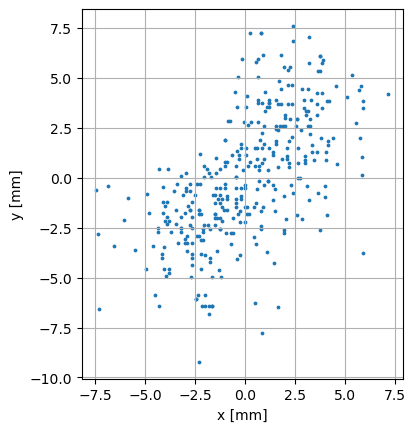

In [ ]:
xyref = np.mean(static_point_rdcoords[:,0:2], axis=0)*1000
xy = static_point_rdcoords[:,0:2]*1000 - xyref

fig, ax = plt.subplots()

plt.scatter(xy[:,0], xy[:,1] , s=3)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.grid()

ax.set_aspect('equal')

plt.show();

**Question 7:** Include the scatterplot in your report (make sure it is for your dataset!) and compare this to the standard deviations of question 4.  What are your conclusions, are the coordinates correlated?

In **Appendix I** we show how to compute the covariance and correlation matrix, and how to add an error elipse to the scatterplot.

Another useful way to display the scatter is to plot the data as an histogram:

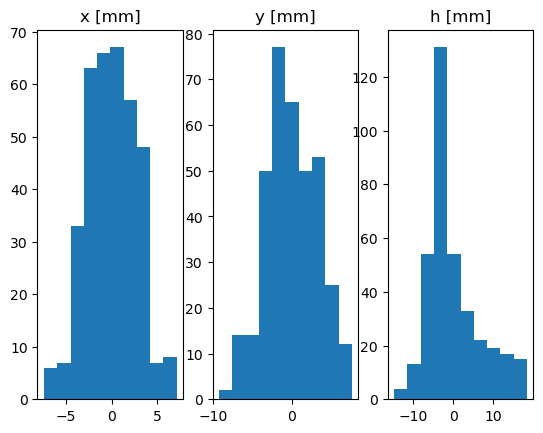

In [ ]:
xyzref = np.mean(static_point_rdcoords, axis=0)*1000
xyz = static_point_rdcoords*1000 - xyzref

fig, (ax0, ax1, ax2) = plt.subplots(1,3)

ax0.hist(xyz[:,0])
ax1.hist(xyz[:,1])
ax2.hist(xyz[:,2])
ax0.set_title('x [mm]')
ax1.set_title('y [mm]')
ax2.set_title('h [mm]')

plt.show();

**Question 8:** Include the three position coordinate histograms in your report (make sure it is for your dataset!).

## 6.3 Analysis of GNSS measurement precision - Part 2

Now we do the same kind of analysis for the measurements without tripod. This data is recorded in the points layer.

### Do this yourself ###

First, we have to locate the benchmark data in the points layer so that we can isolate and save this data as a `numpy` array. So, first let's inspect the Points layer

In [ ]:
mypoints

,UUID,FID,_description,latitude,longitude,elevation,ortho_ht,time,fix_id,h_accuracy,v_accuracy,speed,bearing,name,control_point,remarks,geometry
0,8cfe3f04-edee-4e00-988a-7e0d8967d657,1,p2,51.99741,4.37598,42.560,0.0,19-02-2024 16:03:59.000 CET,4,0.01,0.01,0.023,0.0,,no,,POINT Z (4.37598 51.99741 42.56042)
1,d5563abc-a045-414d-8eef-4f8bf254d4b8,2,p2,51.99741,4.37598,42.570,0.0,19-02-2024 16:04:02.000 CET,4,0.01,0.01,0.004,0.0,,no,,POINT Z (4.37598 51.99741 42.57042)
2,18f10f75-9102-445a-b8ec-a36672654fee,3,p2,51.99741,4.37598,42.562,0.0,19-02-2024 16:04:03.000 CET,4,0.01,0.01,0.004,0.0,,no,,POINT Z (4.37598 51.99741 42.56242)
3,113291e5-f17d-454a-975f-b3715924f520,4,p2,51.99741,4.37598,42.564,0.0,19-02-2024 16:04:04.000 CET,4,0.01,0.01,0.008,0.0,,no,,POINT Z (4.37598 51.99741 42.56442)
4,1b8c12fe-c0de-4ed7-b079-03012b5eab0a,5,p2,51.99741,4.37598,42.562,0.0,19-02-2024 16:04:05.000 CET,4,0.01,0.01,0.005,0.0,,no,,POINT Z (4.37598 51.99741 42.56242)
5,24f33ff4-977d-487a-9a4f-f601f52a2034,6,p2,51.99741,4.37598,42.569,0.0,19-02-2024 16:04:08.000 CET,4,0.01,0.01,0.007,0.0,,no,,POINT Z (4.37598 51.99741 42.56942)
6,9ac527e0-d04b-4919-baa9-e53cd248e11f,7,p2,51.99741,4.37598,42.570,0.0,19-02-2024 16:04:10.000 CET,4,0.01,0.01,0.006,0.0,,no,,POINT Z (4.37598 51.99741 42.57042)
7,c09ff94e-e8d6-443b-a689-c3961c39b2af,8,p2,51.99741,4.37598,42.568,0.0,19-02-2024 16:04:12.000 CET,4,0.01,0.01,0.013,0.0,,no,,POINT Z (4.37598 51.99741 42.56842)
8,d88d3cc0-b7ef-46a9-8a7a-8b0a9156335b,9,p2,51.99741,4.37598,42.568,0.0,19-02-2024 16:04:13.000 CET,4,0.01,0.01,0.011,0.0,,no,,POINT Z (4.37598 51.99741 42.56842)


It is possible that the layer contains only benchmark data, but it is also possible that you have to select data using either the "_description" or "name" attributes. We save this data in an new variable called *mypoints_rd* while converting the coordinates into RD. At the same time we save the data from the tripod experiment to a variable called *mytracks_rd*.

In [ ]:
# Benchmark data with tripod
#mypoints_rd = mypoints.query( "name == 'p#'" ).to_crs("EPSG:28992")           # adjust this to suit your needs
#mypoints_rd = mypoints.query( "_description == 'p#'" ).to_crs("EPSG:28992")
mypoints_rd = mypoints.query( "_description == 'p2'" ).to_crs("EPSG:28992")

# Benchmark data collected with tripod
# mytracks_rd = mytracks.loc[[my_benchmark_trackidx]].to_crs("EPSG:28992")
mytracks_rd = mytracks.loc[[my_benchmark_trackidx]].to_crs("EPSG:28992")

To check your selection plot the data

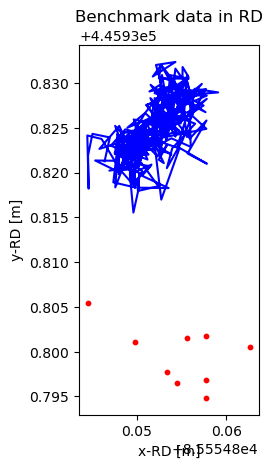

In [ ]:
mybase = mytracks_rd.plot(color='blue')
mypoints_rd.plot(ax=mybase, marker='o', color='red', markersize=10)
mybase.set(xlabel='x-RD [m]', ylabel='y-RD [m]', title='Benchmark data in RD');

To save the coordinates into a numpy array is a bit more complicated; this involves using a loop, with Pythons list comprehension.

In [ ]:
tmplist = [[x.x, x.y, x.z]  for x in mypoints.to_crs('EPSG:28992').geometry]
mypoints_array_rd = np.array(tmplist)
mypoints_array_rd

array([[8.55548446e+04, 4.45930805e+05, 4.25604200e+01],
       [8.55548545e+04, 4.45930797e+05, 4.25704200e+01],
       [8.55548577e+04, 4.45930802e+05, 4.25624200e+01],
       [8.55548556e+04, 4.45930802e+05, 4.25644200e+01],
       [8.55548577e+04, 4.45930797e+05, 4.25624200e+01],
       [8.55548498e+04, 4.45930801e+05, 4.25694200e+01],
       [8.55548534e+04, 4.45930798e+05, 4.25704200e+01],
       [8.55548627e+04, 4.45930801e+05, 4.25684200e+01],
       [8.55548577e+04, 4.45930795e+05, 4.25684200e+01]])

Next we can compute the standard deviation

In [ ]:
mypoints_array_rd.std(axis=0, ddof=1)

array([0.00524868, 0.0033159 , 0.0038873 ])

To compare this to Part 1, we recompute the standard deviations from Part 1 so that you don't have to browse backwards in the notebook

In [ ]:
mytracks_array_rd = np.array(mytracks_rd.geometry[0].coords)
mytracks_array_rd.std(axis=0,ddof=1)

array([0.00273586, 0.00316975, 0.00670216])

Besides computing the standard deviations with and without tripod, you can also look at the difference between the mean of series with tripod and without tripod.

In [ ]:
mypoints_array_rd.mean(axis=0)-mytracks_array_rd.mean(axis=0)

array([ 0.00293446, -0.0251806 , -0.00179896])

**Question 9:** Include in your report the standard deviations of the experiment without tripod and the mean difference between the two experiments (with and without tripod), together with your conclusions.

In [ ]:
rd = np.array(mypoints.query( "_description == 'p2'" )[['longitude', 'latitude','elevation']])
rd

array([[ 4.37598005, 51.99740995, 42.56      ],
       [ 4.37598019, 51.99740987, 42.57      ],
       [ 4.37598024, 51.99740992, 42.562     ],
       [ 4.37598021, 51.99740992, 42.564     ],
       [ 4.37598024, 51.99740988, 42.562     ],
       [ 4.37598012, 51.99740991, 42.569     ],
       [ 4.37598017, 51.99740988, 42.57      ],
       [ 4.37598031, 51.99740991, 42.568     ],
       [ 4.37598024, 51.99740986, 42.568     ]])

## 6.4 Analysis of the coordinate accuracy - checking the coordinates

The coordinates of the benchmarks **P1**, **P2**, **P3** and **P4** are very well known from dedicated measurement campaigns.  These coordinates are used to compare with your own data and to make sure that your data is consistent with other measurements.

The coordinates for **P1**, **P2**, **P3** and **P4** can be obtained from the **TU Delft GNSS Fieldlab** webpage
http://gnss1.tudelft.nl/dlab/station/GNSS_Fieldlab_Coordinates.html .

Coordinates are given as longitude, latitude and elevation are in ETRS89 (Dutch national realization based on ETRF2000) and in RD and NAP (Normaal Amsterdams Peil).

The RD and NAP coordinates have been computed using the official RDNAPTRANS(TM) procedure using PCTrans from the ministry of Defense (https://www.defensie.nl/downloads/applicaties/2021/06/30/pctrans5_20210630). This coordinate transformation is centimeter accurate, as opposed to the one provided by `EPSG:28992`. Later we shall also do a more accurate transformation using `PROJ` in Python.

### Do this yourself ###

Go to the GNSS Fieldlab webpage and save the longitude, latitude and ellipsoidal height (in this order) in the array `ref_llh` and the RD/NAP coordinates in the array `ref_rd`

In [ ]:
ref_name = [ 'P2' ]
ref_llh = np.array([ 4.3759798694, 51.9974098944, 42.5616])
ref_rd = np.array([85554.8333, 445930.7938, -0.9567])

We are going to compare these to the values of the tripod measurements.

Recall that the mean of the tripod measurements were stored in the variables `tripod_mean_llh` and `tripod_mean_rd`.

#### Difference between measured in EPSG:28992 and reference in RD/NAP

In [ ]:
diff_rd = tripod_mean_rd - ref_rd
print('Difference in RD: ', diff_rd[:2]*1000, ' mm')
print('Difference in Height: ', diff_rd[2], ' m')

Difference in RD:  [18.62040775 30.95841251]  mm
Difference in Height:  43.5248078453039  m


This is not entirely what we expected, especially in the height. The explanation for this is:

* The external RD and NAP coordinates, given by *ref_rd*, have been computed using the official RDNAPTRANS(TM) procedure with PCTrans from the ministry of Defense (https://www.defensie.nl/downloads/applicaties/2021/06/30/pctrans5_20210630). This coordinate transformation is centimeter accurate.

* The measured coordinates, given by *tripod_mean_rd*, have been computed using the inbuild CRS transformation, using the `.to_crs('EPSG:28992')` method. The coordinate conversion provided by `EPSG:28992` is officially only to the meter accurate and only operates on the latitude and longitude, not the height.

Actually the differences in RD are surprisingly small considering that `EPSG:28992` is officially only accurate at the meter level, but this is just luck (for Delft). Differences can increase up to 1-2 dm in other parts of the Netherlands!

We will need to do a more accurace and complete coordinate transformation on the measured coordinates for this to work!!

This is the topic of **section 7**, which is also necessary to generate reliable heights in NAP for the DEM.
In **Appendix II** we plot, as an extra, a map of the differences over the Netherlands, and a map with the elevation of the NAP reference surface above the ellipsoid.

#### Difference between measured and reference in geographic coordinates

The differences in longitude (deg), latitude (deg) and elevation (m) are:

In [ ]:
diff_llh = tripod_mean_llh - ref_llh
print('Difference in Longitude and Latitude: ', diff_llh[:2], ' deg')
print('Difference in Height: ', diff_llh[2]*1000, ' mm')

Difference in Longitude and Latitude:  [2.78698527e-07 2.32087061e-07]  deg
Difference in Height:  6.5078453039006945  mm


The difference in height should now be much smaller, but four us humans, the extremely small differences in longitude and lattitude are difficult to interpret.

Using eqs. (29.6) and (29.7) from the Surveying and Mapping book (page 266) small differences in latitude and longitude can be converted into units of meters.

First, we get the semi-major axis (*a*) and inverse flattening (*finv*) for the ellipsoid from one of the GeoDataFrames, and compute some other ellipsoid parameters that are needed later on:

In [ ]:
crscf = points.crs.to_cf()
a = crscf['semi_major_axis']
finv = crscf['inverse_flattening']
f = 1/finv
e2 = 2*f - f**2

print('a, finv:', a, finv)

a, finv: 6378137.0 298.257223563


Then we compute the scaling factors (deg -> meters) for the latitude and longitude using eqs. (29.6) for the radius of curvature and the conversion factors from (29.7):

In [ ]:
lat0=ref_llh[1]                  # reference latitude in degrees (52 degrees)
lat0rad = np.deg2rad(lat0)       # reference latitude in radians

N = a / np.sqrt(1 - e2 * np.sin(lat0rad)**2)      # radius of curvatures
M = N * (1 -e2) / ( 1 - e2 * np.sin(lat0rad)**2)
flat= M * np.pi / 180                          # conversion factors deg -> m
flon= N*np.cos(lat0rad) * np.pi / 180

print('lat, flat, flon:', lat0, flat, flon)

lat, flat, flon: 51.9974098944 111267.30407966315 68681.97965333259


In this conversion the height above the ellipsoid is ignored, therefore, the resulting metrics are on the surface of the ellipsoid.

The differences in East (longitude direction), North (latitude direction) and elevation, in cm (explaining the factor `100` in the code), are:

In [ ]:
diff_enu = diff_llh.copy()
diff_enu[0] =  diff_llh[0]*flon
diff_enu[1] =  diff_llh[1]*flat

print('Difference in East, North and Up (with tripod) in mm:\n', diff_enu *1000)

Difference in East, North and Up (with tripod) in mm:
 [19.14156659 25.82370155  6.5078453 ]


The differences for the case without tripod are computed in the next cell

In [ ]:
tmplist = [[x.x, x.y, x.z]  for x in mypoints.query( "_description == 'p2'" ).geometry]
mypoints_array_llh = np.array(tmplist)

diff_enu_notripod = ( mypoints_array_llh.mean(axis=0) - ref_llh ) * [ flon, flat, 1]

print('Difference in East, North and Up (without tripod) in mm:\n', diff_enu_notripod *1000)

Difference in East, North and Up (without tripod) in mm:
 [22.42644697  0.68491252  4.70888889]


**Question 10:** Include these differences in your report and compare these with the standard deviations from the previous section. Explain in your report why these differences are smaller/larger than the standard deviations. Some hints are provided below, what can you say about your case?

In general these differences should be significantly larger than the standard deviations from the previous section, which represent the internal precision of the GNSS system. There are a couple of factors that contribute to the error budget, that could provide an explanation:

- the pole deviated from the vertical and/or the bubble level has an error
- the length of the pole was entered incorrectly
- the height of the antenna phase center above the antenna reference point is not correct (this can happen for the rover as well as for the reference station), or the software may not apply the antenna height for the reference station correctly (this height should be broadcast by a special RTCM message)
- the coordinates of the reference station are in error
- systematic error in the GNSS (a obvious culprit is the ionosphere delay, if not modelled correctly, this results in a scale error)
- human error (e.g. wrong point)

When the differences are in the few cm range, human errors in occupying the wrong point, or mistakes in entering the antenna height, can be ruled out, though a few cm error in holding the pole vertical is easy to make.

If one of the differences is smaller, or the same order of magnitude, as the standard deviation, then this is just coincidence (can happen statistically).

## 7. RDNAPTRANS™2018 - Official Coordinate transformation between RD, NAP and ETRS89

RDNAPTRANS (https://www.nsgi.nl/rdnaptrans) is the name of the official Dutch transformation procedure between RD (Rijksdriehoeksmeting), NAP (Normaal Amsterdams Peil) and ETRS89 (European Terrestrial Reference System 1989). The current version is RDNAPTRANS™2018. RDNAPTRANS is maintained by the Nederlandse Samenwerking Geodetische Infrastructuur (NSGI). This version is accurate at the cm level.

The following implementations and API are available (https://www.nsgi.nl/web/nsgi/geodetische-infrastructuur/coordinatentransformatie):

- PCTrans: A freely available Windows 10 application for geodetic and hydrographic computations from the Hydrographic Service (https://www.defensie.nl/downloads/applicaties/2021/06/30/pctrans5_20210630)
- Web based API provided by NSGI (https://www.nsgi.nl/coordinatentransformatie-api), API-key required
- Implementations of RDNAPTRANS™2018 by software providers (validated by NSGI)

RDNAPTRANS™2018 can be implemented using the Transform method from the Python-3 `pyproj` package with PROJ version 7.x or higher. Two additional files are required: the geoid file `nlgeo2008.gtx` and transformation grid file `rdcorr2018.gsb` must be present in the same folder as this module.

Not only is RDNAPTRANS more accurate than the `.to_crs('EPSG:28992')` method, **but RDNAPTRANS is also able to convert ellipsoidal height into NAP heights**, something we need for our Digital Elevation Model (DEM).

In **Appendix II** we plot, as an extra, a map of the differences over the Netherlands, and a map with the elevation of the NAP reference surface above the ellipsoid.

Reference:

Jochem Lesparre, Lennard Huisman and Bas Alberts (2020), RDNAPTRANS™2018 - Coordinate transformation to and from Stelsel van de Rijksdriehoeksmeting and Normaal Amsterdams
Peil, Nederlandse Samenwerking Geodetische Infrastructuur, 5 Feb 2020.

#### 7.1 Pyproj implementation of RDNAPTRANS

RDNAPTRANS™2018 requires the Python-3 `pyproj` package with PROJ version 7.x or higher. Before continuing, check if you are using PROJ version 7.x or higher:

In [ ]:
pyproj.show_versions()

pyproj info:
    pyproj: 3.4.1
      PROJ: 9.1.1
  data dir: C:\Programs\Anaconda3\envs\geospatial\Library\share\proj
user_data_dir: C:\Users\hvandermarel\AppData\Local/proj
PROJ DATA (recommended version): 1.12
PROJ Database: 1.2
EPSG Database: v10.076 [2022-08-31]
ESRI Database: ArcGIS Pro 3.0 [2022-07-09]
IGNF Database: 3.1.0 [2019-05-24]

System:
    python: 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:12:32) [MSC v.1929 64 bit (AMD64)]
executable: C:\Programs\Anaconda3\envs\geospatial\python.exe
   machine: Windows-10-10.0.19045-SP0

Python deps:
   certifi: 2022.12.7
    Cython: None
setuptools: 67.4.0
       pip: 23.0.1


RDNAPTRANS™2018 is implemented using the `pyproj` Transform method. A `pyproj.Transformer` object `rdnaptrans2018` is created with the transformation parameters given by the variable  `pipeline_3d`. The transformer object is used to create the functions `etrs89_to_rdnap(lat, lon, elevation) -> x, y, H` and the inverse transformation `rdnap_to_etrs89(x, y, H) -> lat, lon, elevation`:

In [ ]:
# Define variables with the PROJ transform pipeline and pyproj.Transformer object

pipeline_3d = (
    '+proj=pipeline '
    '+step +proj=unitconvert +xy_in=deg +z_in=m +xy_out=rad +z_out=m '
    '+step +proj=axisswap +order=2,1,3,4 '
    '+step +proj=vgridshift +grids=./nlgeo2018.gtx '
    '+step +proj=push +v_3 '
    '+step +proj=set +v_3=43 +omit_inv '
    '+step +proj=cart +ellps=GRS80 '
    '+step +proj=helmert +x=-565.7346 +y=-50.4058 +z=-465.2895 +rx=-0.395023 '
    '+ry=0.330776 +rz=-1.876073 +s=-4.07242 +convention=coordinate_frame +exact '
    '+step +proj=cart +inv +ellps=bessel '
    '+step +proj=hgridshift +inv +grids=./rdcorr2018.gsb,null '
    '+step +proj=sterea +lat_0=52.156160556 +lon_0=5.387638889 +k=0.9999079 '
    '+x_0=155000 +y_0=463000 +ellps=bessel '
    '+step +proj=set +v_3=0 +omit_fwd '
    '+step +proj=pop +v_3'
)

rdnaptrans2018 = pyproj.Transformer.from_pipeline(pipeline_3d)

# Define function with forward transformation

def etrs89_to_rdnap(lon, lat, elevation):
    # x, y, H = etrs89_to_rdnap(lon, lat, elevation)
    return rdnaptrans2018.transform(lat, lon, elevation, direction='FORWARD')

# Define function with inverse transformation

def rdnap_to_etrs89(x, y, H):
    # lon, lat, elevation = rdnap_to_etrs89_3d(x, y, H):
    lat, lon, elevation = rdnaptrans2018.transform(x, y, H, direction='INVERSE')
    return lon, lat, elevation


Note that the `pipeline_3d` variable contains references to the geoid file `nlgeo2008.gtx` (line 4) and transformation grid file `rdcorr2018.gsb` (line 11), which are expected to be present in the same folder as this notebook. If these files are stored in a different location, you have to adjust the path in the `pipeline_3d` variable. If these files are not present in the expected location the `Transformer` object returns an error!

We test the transformation using the reference coordinates.

In [ ]:
tmp = etrs89_to_rdnap( ref_llh[0], ref_llh[1], ref_llh[2])
print('difference (in mm):\n', (tmp - ref_rd)*1000)

difference (in mm):
 [-0.00571844  0.01985766 -0.01499329]


You should get differences that are smaller than one millimeter. Check!

Now lets check the inverse transformation:

In [ ]:
tmp = rdnap_to_etrs89( ref_rd[0], ref_rd[1], ref_rd[2])
print('difference (in mdeg/mdeg/mm):\n', (tmp - ref_llh)*1000)

difference (in mdeg/mdeg/mm):
 [ 7.78674902e-08 -9.77706804e-08  1.49933920e-02]


A *mdeg* is one milli degree (1/1000 of a degree).

The two functions also operate on arrays in case you desire to transform many coordinates at once. For example, this allows us to convert elevation above the ellipsoid to NAP height for the Digital Elevation Model (DEM).

#### 7.2 Comparison with official RD/NAP coordinates (revisited)

In **section 6** we compared - without success - your tripod measurements with the official RD/NAP coordinates.

To do this properly, you have to convert the latitude, longitude and elevation for your tripod measurements, given in ETRS89, into RD/NAP coordinates using the official RDNAPTRANS2018 transformation, and then compare.

In [ ]:
tripod_mean_rdnaptrans = etrs89_to_rdnap( tripod_mean_llh[0], tripod_mean_llh[1], tripod_mean_llh[2])
tripod_mean_rdnaptrans

(85554.85279231866, 445930.81937307713, -0.9502069138963947)

The difference with the reference coordinates is now

In [ ]:
diff_rdnaptrans = tripod_mean_rdnaptrans - ref_rd
print('Difference in RD/NAP in mm:\n', diff_rdnaptrans*1000)

Difference in RD/NAP in mm:
 [19.49231866 25.57307715  6.4930861 ]


Compare this result to the method using geographic coordinates with conversion factors

In [ ]:
print('Difference in East, North and Up (with tripod) in mm:\n', diff_enu *1000)

Difference in East, North and Up (with tripod) in mm:
 [19.14156659 25.82370155  6.5078453 ]


The differences should be very similar!

## 8. Computing a Digital Elevation Model (DEM)

During the practical you collected position and elevation measurements on a grid from which you will compute a Digital Elevation Model (DEM).

The data was stored in your dataset as a track. In our dataset this was the second track, but this may be different in yours!

In [ ]:
demidx=1

Extract this track as a numpy array and convert into RDNAP:

In [ ]:
dem_data_geo = np.array(tracks.geometry[demidx].coords)
print('shape',dem_data_geo.shape)

shape (193, 3)


In [ ]:
xRD, yRD, HNAP = etrs89_to_rdnap(dem_data_geo[:,0], dem_data_geo[:,1], dem_data_geo[:,2] )

The difference between NAP and ellipsoida height is

In [ ]:
hdif = HNAP - dem_data_geo[:,2]
print(np.mean(hdif),np.std(hdif))

-43.51842082190008 3.798513511793543e-05


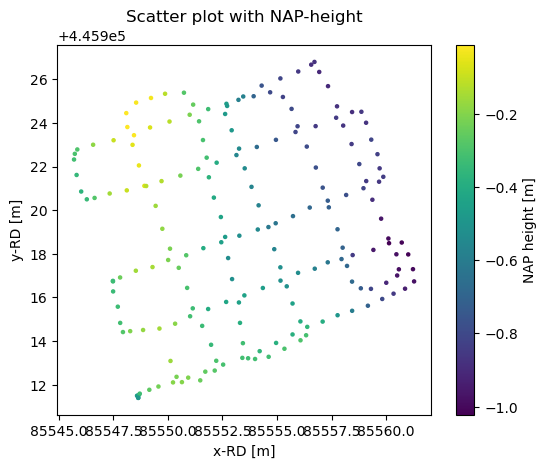

In [ ]:
fig, ax = plt.subplots()

plt.scatter(xRD, yRD ,c=HNAP, s=5)
plt.xlabel('x-RD [m]')
plt.ylabel('y-RD [m]')
plt.title('Scatter plot with NAP-height')
plt.colorbar(label='NAP height [m]')

ax.set_aspect('equal')

plt.show();

In [ ]:
from matplotlib.tri import Triangulation, LinearTriInterpolator

In [ ]:
npts=100

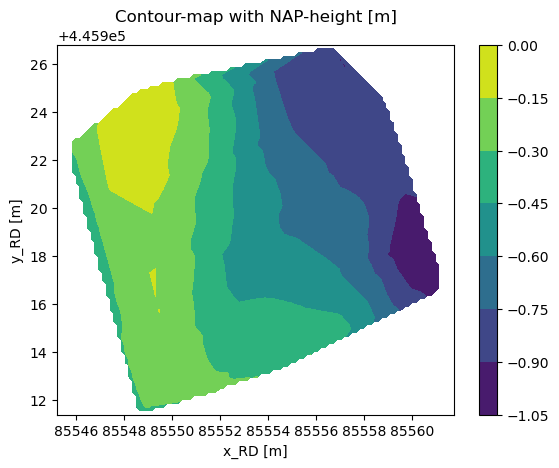

In [ ]:
triObj = Triangulation(xRD,yRD)      # measured locations form an irregular grid they serve as vertices (nodes) of triangular interpolation
                                        # see chapter 11 in the book on Surveying and Mapping
fz = LinearTriInterpolator(triObj,HNAP) # linear interpolation (of terrain height) within triangles

min_x = np.amin(xRD)                 # determine the boundaries of the (horizontal) area of interest
max_x = np.amax(xRD)
min_y = np.amin(yRD)
max_y = np.amax(yRD)

xnew = np.linspace(min_x,max_x,npts) # set-up new, regular grid
ynew = np.linspace(min_y,max_y,npts)
xxnew, yynew = np.meshgrid(xnew, ynew) # meshgrid to turn new 1D arrays into grid-array coordinates

znew = fz(xxnew,yynew)               # do actual interpolation to new, regular grid

fig = plt.figure()
cs = plt.contourf(xnew, ynew, znew)  # produce contour-map
cb = plt.colorbar(cs)                # add color-bar for height
plt.title('Contour-map with NAP-height [m]')
plt.xlabel('x_RD [m]')
plt.ylabel('y_RD [m]')
plt.axis('equal')

plt.show()

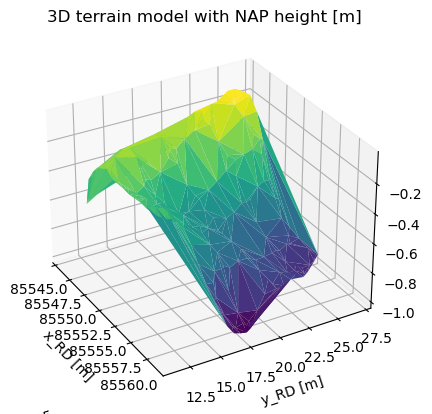

In [ ]:
ax = plt.figure().add_subplot(projection='3d')
colormap = 'viridis'
surf = ax.plot_trisurf(xRD, yRD, HNAP, cmap=colormap, antialiased = True)
ax.view_init(30,330)             # set viewing angle - default (elevation=30deg, azimuth=300deg), i.e. looking from South-East
plt.title('3D terrain model with NAP height [m]')
plt.xlabel('x_RD [m]')
plt.ylabel('y_RD [m]')

plt.show();

### Do this yourself

Compute the contour map and 3D DEM for your own dataset using the above code examples

In [ ]:
# Include your code here

**Question 11:** Include the contour map and the 3D DEM in your report.

[End of the assignment]

## Appendix I - Plotting confidence ellipses

As an extra, having all units equal, it becomes now easy to compute the co-variance and correlation matrices:

In [ ]:
np.cov(static_point_rdcoords, rowvar=False)

array([[7.48490888e-06, 5.23562097e-06, 8.07839011e-06],
       [5.23562097e-06, 1.00473229e-05, 8.34413623e-06],
       [8.07839011e-06, 8.34413623e-06, 4.49189100e-05]])

In [ ]:
np.corrcoef(static_point_rdcoords, rowvar=False)

array([[1.        , 0.60373974, 0.44057207],
       [0.60373974, 1.        , 0.39277298],
       [0.44057207, 0.39277298, 1.        ]])

With a small helper function (from https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html), a 95% reliability standard error ellips can be added to the plot:

In [ ]:
# Helper function to plot standard ellipses. Source: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

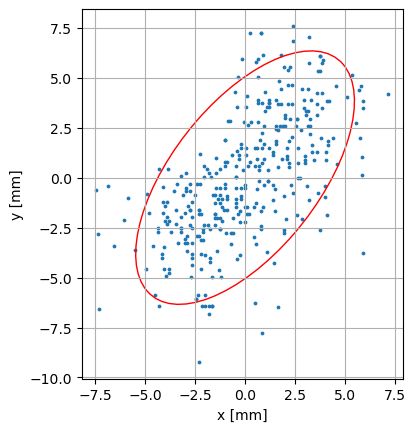

In [ ]:
fig, ax = plt.subplots()

ax.scatter(xy[:,0], xy[:,1], s=3)
confidence_ellipse(xy[:,0], xy[:,1], ax, n_std=2, edgecolor='red')
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
plt.grid()

ax.set_aspect('equal')

plt.show();

## Appendix II - RDNAPTRANS versus EPSG:28922

In this appendix two maps of the Benelux area are created showing the differences between EPSG:28922 and the official RDNAPTRANS, and the elevation of the NAP reference surface above the ellipoid.

As a first step a *geopackage* is loaded with the coastlines and borders, which will be used as background.

In [ ]:
benelux= geopandas.read_file('Benelux.gpkg')
minx, miny, maxx, maxy = benelux.geometry.total_bounds
print(benelux.crs, minx, maxx, miny, maxy)

EPSG:4326 2.5212895409595575 8.371628267568887 49.27390824151914 53.759861


The next step is to create a grid with longitude and latitude values:

In [ ]:
lats = np.arange(49.3, 54, .1)
lons = np.arange(2.6, 8.6, .1)

latgrid, longrid = np.meshgrid(lats, lons)

With the help of this grid, two sets of RD coordinates are computed: one using EPSG:28922 and the other using the official RDNAPTRANS procedure. The RD coordinate differences are plotted as vectors, color coded with the length of each vector:

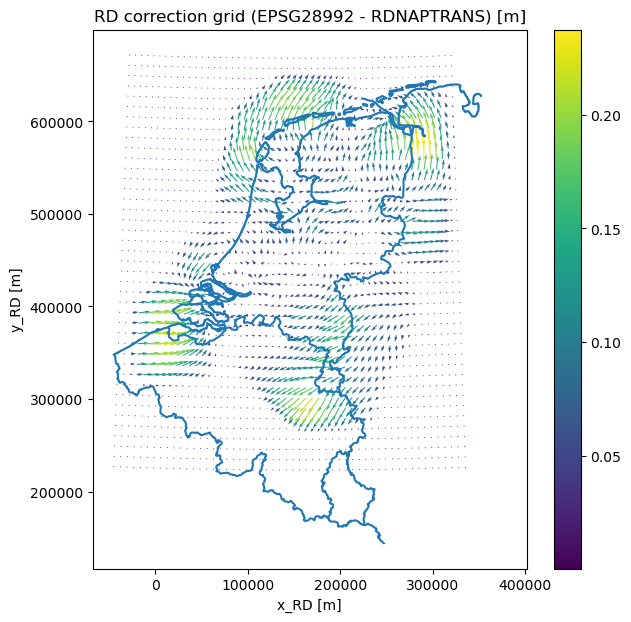

In [ ]:
EPSG28992 = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:28992")

x_EPSG28992, y_EPSG28992 = EPSG28992.transform(latgrid, longrid)   # the transformer expect latitude before longitude
x_rdnaptrans, y_rdnaptrans, h_rdnaptrans = etrs89_to_rdnap(longrid, latgrid, 44*np.ones(np.shape(longrid)))

m = np.sqrt(np.power(x_EPSG28992-x_rdnaptrans, 2) + np.power(y_EPSG28992-y_rdnaptrans, 2))

fig, ax = plt.subplots(figsize=(7,7))
plt.quiver(x_EPSG28992, y_EPSG28992, x_EPSG28992-x_rdnaptrans, y_EPSG28992-y_rdnaptrans , m)
plt.colorbar()
benelux.to_crs("EPSG:28992").plot(ax=ax)
plt.title('RD correction grid (EPSG28992 - RDNAPTRANS) [m]')
plt.xlabel('x_RD [m]')
plt.ylabel('y_RD [m]')
plt.axis('equal')
plt.show()

For the same grid (but now in RD coordinates) the elevation of the NAP reference surface (with NAP height == 0) above the ellipsoid is computed:

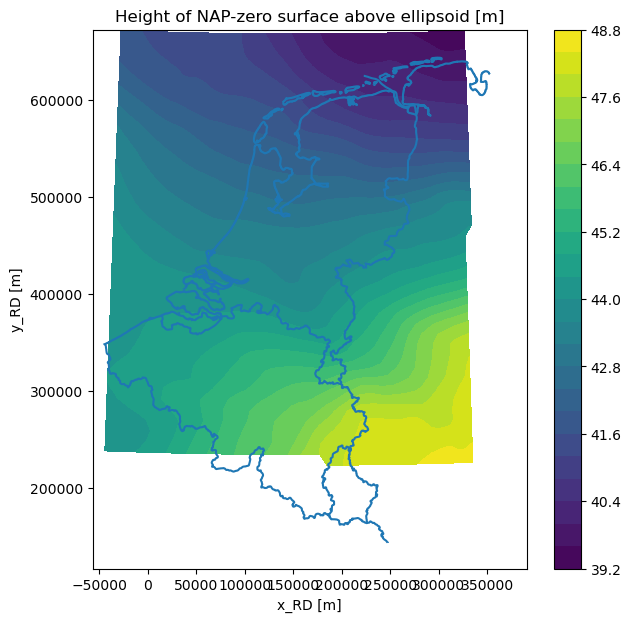

In [ ]:
dummy1, dummy2, h_rdnaptrans = rdnap_to_etrs89(x_EPSG28992, y_EPSG28992, np.zeros(np.shape(x_EPSG28992)))

fig, ax = plt.subplots(figsize=(7,7))
cs = plt.contourf(x_EPSG28992, y_EPSG28992, h_rdnaptrans, 30)  # produce contour-map
cb = plt.colorbar(cs)                # add color-bar for height
benelux.to_crs("EPSG:28992").plot(ax=ax)
plt.title('Height of NAP-zero surface above ellipsoid [m]')
plt.xlabel('x_RD [m]')
plt.ylabel('y_RD [m]')
plt.axis('equal')
plt.show()

The NAP height and elevation above the ellipsoid differ by about 40 - 48 meters.

[End of Jupyter notebook]